## Preparation (40 points total)

* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   
* [15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
* [15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling (50 points total)

* [20 points] Create a convolutional neural network to use on your data using tensorflow. 
* [20 points] Investigate at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs. 
* [10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

## Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Visualize the convolutional filters chosen by your CNN. Try to interpret some of their meanings.

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics as mt
import numpy as np
print(keras.__version__)

Using TensorFlow backend.


2.0.3


In [2]:
l2_lambda = 0.0001

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.
)
datagen.fit(x_train)

## Metrics

In [3]:
# from keras version < 2.0 https://github.com/fchollet/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7#diff-7b49e1c42728a58a9d08643a79f44cd4L134
from keras import backend as K
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batcwise average of precision.

    Computes the precision, a metric for multlabel classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batcwise average of recall.

    Computes the recall, a metric for multlabel classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
 
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batchwise average, not globally.

    This is useful for multilabel classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The Fbeta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a Fmeasure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

 
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [37]:
# pretty confusion matrices

from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.f1_score(y_test,yhat, average="macro")
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [5]:
def plot_roc(probas, y_true):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += mt.auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')
    

In [8]:
from scipy.misc import imresize

x_train_up = [imresize(x,size=(64,64,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(64,64,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [10]:
%%time
# build model
lenet = Sequential()
lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (64,64,3), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))
lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy', fmeasure])

# the flow method yields batches of images indefinitely, with the given transofmrations
lenet.fit_generator(datagen.flow(x_train_up, y_train_ohe, batch_size=64), 
  steps_per_epoch=int(len(x_train_up)/64), # how many generators to go through per epoch
  epochs=50, verbose=2,
  validation_data=(x_test_up,y_test_ohe),
  callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
 )

Epoch 1/50
111s - loss: 1.8849 - acc: 0.3290 - fmeasure: 0.1135 - val_loss: 2.3462 - val_acc: 0.2076 - val_fmeasure: 0.0702
Epoch 2/50
111s - loss: 1.5082 - acc: 0.4705 - fmeasure: 0.3368 - val_loss: 1.4632 - val_acc: 0.4952 - val_fmeasure: 0.4346
Epoch 3/50
110s - loss: 1.3939 - acc: 0.5104 - fmeasure: 0.4217 - val_loss: 1.6650 - val_acc: 0.4567 - val_fmeasure: 0.4192
Epoch 4/50
110s - loss: 1.3199 - acc: 0.5375 - fmeasure: 0.4706 - val_loss: 1.7028 - val_acc: 0.4260 - val_fmeasure: 0.3506
Epoch 5/50
111s - loss: 1.2653 - acc: 0.5597 - fmeasure: 0.5024 - val_loss: 1.9361 - val_acc: 0.3882 - val_fmeasure: 0.3298
Epoch 6/50
111s - loss: 1.2285 - acc: 0.5752 - fmeasure: 0.5231 - val_loss: 1.8376 - val_acc: 0.4002 - val_fmeasure: 0.3434
Epoch 7/50
110s - loss: 1.1994 - acc: 0.5825 - fmeasure: 0.5396 - val_loss: 1.7433 - val_acc: 0.4289 - val_fmeasure: 0.3968
Epoch 8/50
110s - loss: 1.1760 - acc: 0.5926 - fmeasure: 0.5531 - val_loss: 1.7814 - val_acc: 0.4533 - val_fmeasure: 0.4121
Epoch 9/

KeyboardInterrupt: 

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


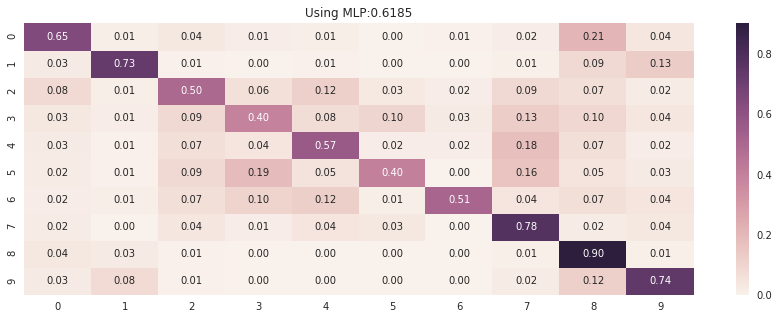

In [25]:
summarize_net(lenet, x_test, y_test, title_text='Using MLP:')

 9632/10000 [===========================>..] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


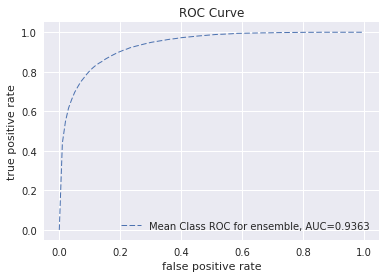

In [26]:
probas = lenet.predict_proba(x_test)
plot_roc(probas, y_test)

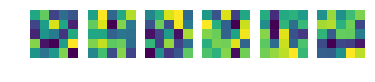

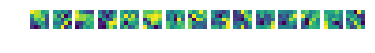

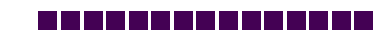

In [6]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()


## Ensemble

In [21]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatx=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/200
1562/1562 [==============================] - 79s - loss: 1.8455 - acc: 0.3187 - val_loss: 1.5328 - val_acc: 0.4500
Epoch 2/200
1562/1562 [==============================] - 76s - loss: 1.5495 - acc: 0.4326 - val_loss: 1.3462 - val_acc: 0.5163
Epoch 3/200
1562/1562 [==============================] - 76s - loss: 1.4256 - acc: 0.4852 - val_loss: 1.2426 - val_acc: 0.5591
Epoch 4/200
1562/1562 [==============================] - 76s - loss: 1.3421 - acc: 0.5196 - val_loss: 1.2099 - val_acc: 0.5693
Epoch 5/200
1562/1562 [==============================] - 76s - loss: 1.2686 - acc: 0.5464 - val_loss: 1.0858 - val_acc: 0.6157
Epoch 6/200
1562/1562 [==============================] - 76s - loss: 1.2128 - acc: 0.5694 - val_loss: 1.0846 - val_acc: 0.6182
Epoch 7/200
1562/1562 [==============================] - 76s - loss: 1.1641 - acc: 0.5861 - val_loss: 0.9972 - val_acc: 0.6539
Epo

KeyboardInterrupt: 

In [26]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', fmeasure])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_60 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_61 (Dropout)         (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 16, 16)        36928     
__________

In [27]:
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 177s - loss: 1.9386 - acc: 0.2847 - fmeasure: 0.0782 - val_loss: 1.6347 - val_acc: 0.4119 - val_fmeasure: 0.1725
Epoch 2/25
50000/50000 [==============================] - 176s - loss: 1.5172 - acc: 0.4455 - fmeasure: 0.3114 - val_loss: 1.3528 - val_acc: 0.5157 - val_fmeasure: 0.3599
Epoch 3/25
50000/50000 [==============================] - 176s - loss: 1.3351 - acc: 0.5164 - fmeasure: 0.4325 - val_loss: 1.2884 - val_acc: 0.5320 - val_fmeasure: 0.4466
Epoch 4/25
50000/50000 [==============================] - 176s - loss: 1.1893 - acc: 0.5736 - fmeasure: 0.5181 - val_loss: 1.1353 - val_acc: 0.5920 - val_fmeasure: 0.5414
Epoch 5/25
50000/50000 [==============================] - 176s - loss: 1.0746 - acc: 0.6147 - fmeasure: 0.5774 - val_loss: 1.0297 - val_acc: 0.6337 - val_fmeasure: 0.6050
Epoch 6/25
50000/50000 [==============================] - 176s - loss: 0.9817 - acc: 0.6505 - f

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


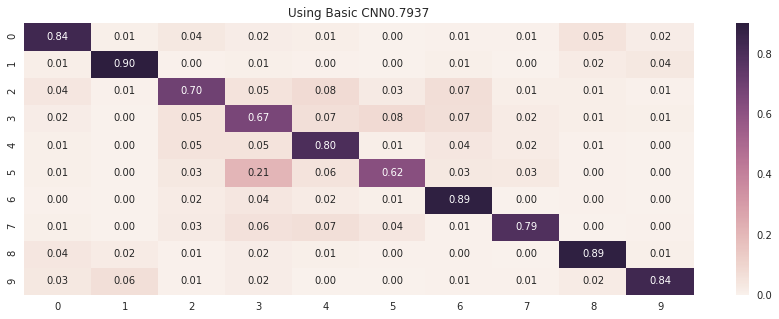

In [38]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = np_utils.to_categorical(y_train)
num_classes = y_test.shape[1]

summarize_net(model, X_test, y_test, title_text='Using Basic CNN')

10000/10000 [==============================] - 11s    


/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


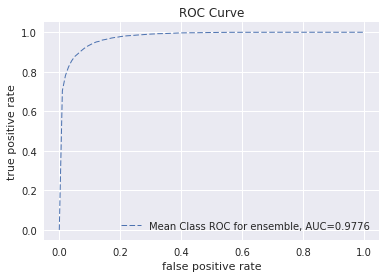

In [39]:
probas = model.predict_proba(X_test)
plot_roc(probas, y_test)

In [40]:
model.save('model_data.h5')

## MLP

In [5]:
%%time
mlp = Sequential()
mlp.add( Reshape((1,3072), input_shape=(32,32,3)) )
mlp.add( Flatten() )
mlp.add( Dense(input_dim=3072, units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy', fmeasure])

mlp.fit(x_train, y_train_ohe, 
        batch_size=32, epochs=35, 
        shuffle=True, verbose=1)

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 9.78 µs
Epoch 1/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 2/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 3/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 4/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 5/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 6/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 7/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 8/35
50000/50000 [==============================] - 7s - loss: 0.1800 - acc: 0.1000 - fmeasure: 0.1000     
Epoch 9/35
50000/50000 [

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


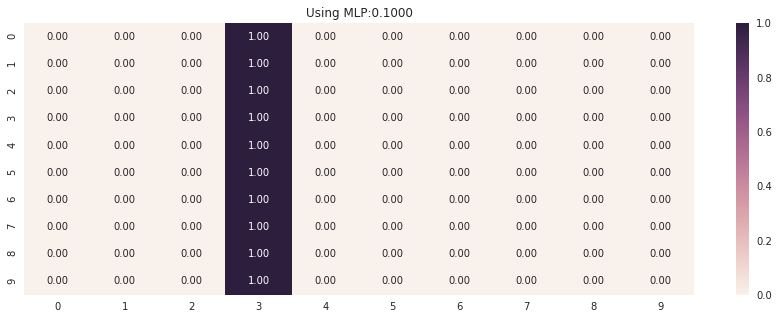

In [15]:
summarize_net(mlp, x_test, y_test, title_text='Using MLP:')

 9664/10000 [===========================>..] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


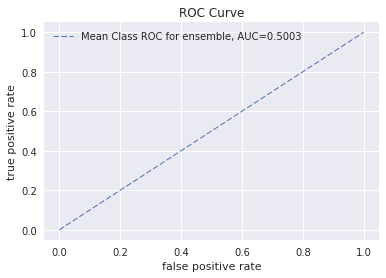

In [22]:
probas = mlp.predict_proba(x_test)
plot_roc(probas, y_test)